<a href="https://colab.research.google.com/github/omarsayed7/Satellite-Segmentation/blob/main/Data_pre_processing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio && GDAL==3.2.2 && paddleseg && paddlepaddle
!pip install pyshp
!pip install geopandas

/bin/bash: paddleseg: command not found


In [ ]:
import math, cv2
import os, sys, subprocess
import numpy as np 
from osgeo import gdal, ogr
import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Dataset/'
SHAPE_PATH = '/content/drive/MyDrive/Dataset/training_dr.Roshdy/training_dr.Roshdy/'
LABEL_OUTPUT = 'label_2017.tif'

In [ ]:
fn_ras = os.path.join(DATASET_PATH,'pansharpening_2017_ortho-002.tif')
fn_vec = os.path.join(SHAPE_PATH,'urban_2017.shp')

In [ ]:
driver = ogr.GetDriverByName("ESRI Shapefile")
ras_ds = gdal.Open(fn_ras)
vec_ds = driver.Open(fn_vec, 1)

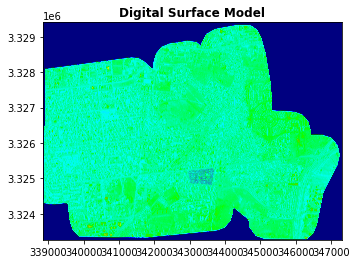

In [ ]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show 
import geopandas as gpd

dsm = rasterio.open(fn_ras)
sf = shp.Reader(fn_vec)


sf=gpd.read_file(fn_vec)

sf.plot()
#plt.figure(figsize=(20, 20))
# for shape in sf.shapeRecords():       
#        xy = [i for i in shape.shape.points[:]]
#        x,y = zip(*[(j[0],j[1]) for j in xy])
# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x,y)
#plt.savefig('original.png', bbox_inches='tight')

show(dsm, title='Digital Surface Model', cmap='gist_ncar')
plt.show(dsm)


In [ ]:
print(sf.total_bounds)

[ 342965.61227621 3324822.50746272  343683.40183081 3325284.0256036 ]


In [ ]:
lyr = vec_ds.GetLayer()
geot = ras_ds.GetGeoTransform()
proj = ras_ds.GetProjection() # Get the projection from original tiff (fn_ras)

In [ ]:
#To get the coordinates of the corners of your geotiff do the following:
width = ras_ds.RasterXSize
height = ras_ds.RasterYSize

minx = geot[0] #lower left x
miny = geot[3] + width*geot[4] + height*geot[5] #lower left y
maxx = geot[0] + width*geot[1] + height*geot[2] #upper right x
maxy = geot[3] #upper right y

minx, miny, maxx, maxy

(338845.5, 3323262.5, 347294.0, 3329407.75)

In [ ]:
#https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
import osr
# get CRS from dataset 
crs = osr.SpatialReference()
crs.ImportFromWkt(ras_ds.GetProjectionRef())
# create lat/long crs with WGS84 datum
crsGeo = osr.SpatialReference()
crsGeo.ImportFromEPSG(4326) # 4326 is the EPSG id of lat/long crs 
t = osr.CoordinateTransformation(crs, crsGeo)
(lat, long, z) = t.TransformPoint(minx, miny)
(lat2, long2, z2) = t.TransformPoint(maxx, maxy)
print(lat, long, z)
print(lat2, long2, z2)

31.32871915268149 30.029787334994044 0.0
31.415424247440246 30.08630776043553 0.0


In [ ]:
#Create Raster image for Labels
input_shp = ogr.Open(fn_vec)
shp_layer = input_shp.GetLayer()

pixel_size = 0.25
#To get the coordinates of the corners of your geotiff do the following:
width = ras_ds.RasterXSize
height = ras_ds.RasterYSize

minx = geot[0] #lower left x
miny = geot[3] + width*geot[4] + height*geot[5] #lower left y
maxx = geot[0] + width*geot[1] + height*geot[2] #upper right x
maxy = geot[3] #upper right y

minx, miny, maxx, maxy

ds = gdal.Rasterize(LABEL_OUTPUT, fn_vec, xRes=pixel_size, yRes=pixel_size, 
                    burnValues=255, outputBounds=[minx, miny, maxx, maxy], 
                    outputType=gdal.GDT_Byte)
ds = None

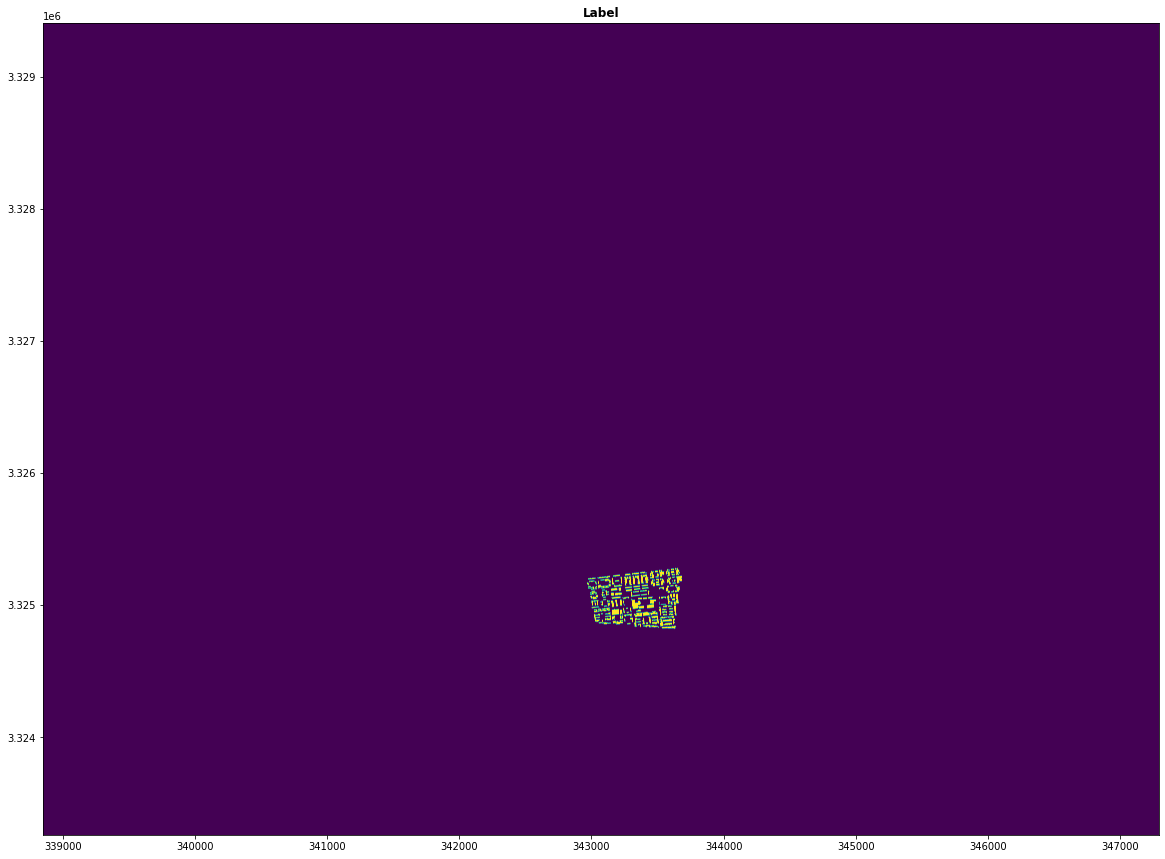

In [ ]:
import rasterio
from rasterio.plot import show 
np.set_printoptions(threshold=sys.maxsize)

label = rasterio.open(LABEL_OUTPUT)
plt.figure(figsize=(20, 20))
show(label, title='Label')


plt.show()
#print(label.read(1))
#file1 = open("MyFile.txt","a")
#file1.write(np.array2string(label.read(1)))
#file1.close()


In [ ]:
!gdalinfo '/content/drive/MyDrive/Dataset/pansharpening_2017_ortho-002.tif'

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Driver: GTiff/GeoTIFF
Files: /content/drive/MyDrive/Dataset/pansharpening_2017_ortho-002.tif
Size is 33794, 24581
Coordinate System is:
PROJCS["LUnits = meters|",
    GEOGCS["WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.2572235604902,
                AUTHORITY["EPSG","7030"]]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",33],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["meters",1]]
Origin = (338845.500000000000000,3329407.750000000000000)
Pixel Size = (0.250000000000000,-0.250000000000000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_RESOLUTIONUNIT=2 (pixels/inch)
  TIFFTAG_S

In [ ]:
!gdalinfo '/content/label_2017.tif'

Driver: GTiff/GeoTIFF
Files: /content/label_2017.tif
Size is 33794, 24581
Coordinate System is:
PROJCS["WGS 84 / UTM zone 36N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",33],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32636"]]
Origin = (338845.500000000000000,3329407.750000000000000)
Pixel Size = (0.250000000000000,-0.250000000000000)
Metadata:
  AREA_OR_POINT=A

In [ ]:
#Second - Splitting raster and rasterized files to small tiles 512×512 
#depends on your memory

In [ ]:
ds = gdal.Open(fn_ras)
gt = ds.GetGeoTransform()

In [ ]:
import math
import os.path as osp
def get_numOf_tiles(source,get_transform,sizeX, sizeY):
    needed_out_x = sizeX
    needed_out_y = sizeY

    xmin = get_transform[0]
    ymax = get_transform[3]
    resx = get_transform[1]
    res_y = get_transform[5]
    resy = abs(res_y)

    xnotround = source.RasterXSize / needed_out_x
    xround = math.ceil(xnotround)
    ynotround = source.RasterYSize / needed_out_y
    yround = math.ceil(ynotround)

    pixtomX = needed_out_x * xround * resx
    pixtomy = needed_out_y * yround * resy

    #size of a single tile
    xsize = pixtomX / xround
    ysize = pixtomy / yround

    #create lists of x and y coordinates
    xsteps = [xmin + xsize * i for i in range(xround + 1)]
    ysteps = [ymax - ysize * i for i in range(yround + 1)]

    return xsteps, ysteps, xround, yround, resx, resy

In [ ]:
#set the output path
base_directory = "DatasetUNet"
data_output_directory = os.path.join(base_directory,"images")
label_output_directory = os.path.join(base_directory,"labels")

if not os.path.exists(base_directory):
    os.mkdir(base_directory)

In [ ]:
#spliting the source tif file iinto (512,512) small tiles
def split_gtif(output_directory, source_tif, tile_name, sizeX, sizeY):
    source = gdal.Open(source_tif)
    gt = source.GetGeoTransform()
    xsteps, ysteps, xround, yround, resx, resy = get_numOf_tiles(source, gt, sizeX,sizeY)

    for i in range(xround):
        for j in range(yround):
            xmin = xsteps[i]
            xmax = xsteps[i + 1]
            ymax = ysteps[j]
            ymin = ysteps[j + 1]
            # gdal translate to subset the input raster
            if not os.path.exists(output_directory):
                os.mkdir(output_directory)

            output_path = osp.join(output_directory,(str(tile_name) + "-" + str(j) + "-" + str(i) + "." + "jpg"))
            if tile_name == "mask" :
                bandList = None
            else:
                bandList =(4,3,2)
            
            try:
                gdal.Translate(output_path, 
                            source,bandList=bandList, # RGB Bands
                            projWin=(abs(xmin), abs(ymax), abs(xmax), abs(ymin)),
                            xRes=resx, 
                            yRes=-resy,
                            format="JPEG", 
                            outputType=gdal.gdalconst.GDT_Byte,
                            scaleParams=[[]])
            except:
                print("Unexpected error color:", sys.exc_info(), gdal.GetLastErrorMsg())
    print("DONE")


In [ ]:
split_gtif(data_output_directory,fn_ras,"img", 512, 512)

DONE


In [ ]:
split_gtif(label_output_directory,LABEL_OUTPUT,"mask", 512, 512)

DONE


In [ ]:
#saving the dataset tiles to drive
!mv DatasetUNet/ /content/drive/MyDrive

In [ ]:
#Showing the (512,512,3) RGB tiles 
from google.colab.patches import cv2_imshow

def images_show(images_directory,num_of_images):
    for img in os.listdir(images_directory):
        img_extension = img.split(".")[-1]
        if img_extension == "jpg" and num_of_images > 0:
            num_of_images -= 1 
            image = cv2.imread(os.path.join(images_directory, img), cv2.IMREAD_UNCHANGED)
            plt.imshow(image)
        plt.show()


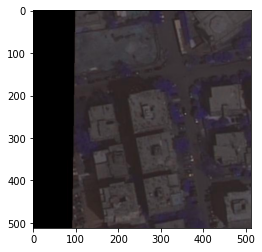

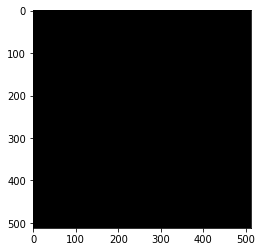

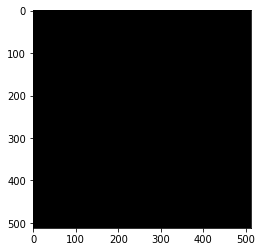

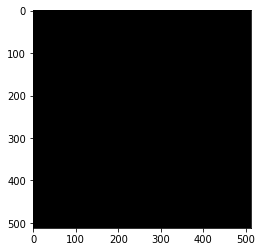

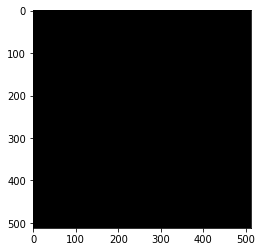

In [ ]:
images_show("/content/drive/MyDrive/DatasetUNet/images",5)

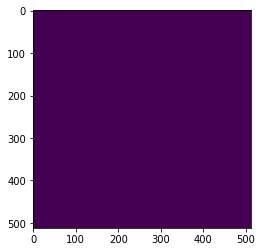

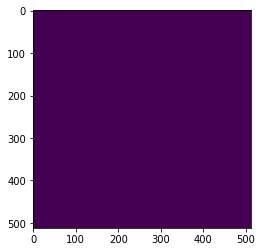

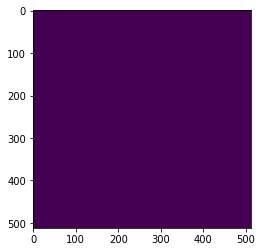

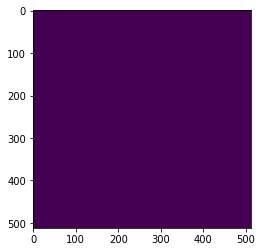

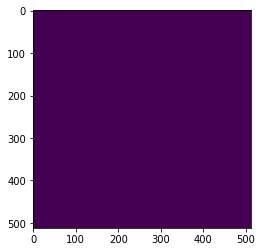

In [ ]:
images_show("/content/drive/MyDrive/DatasetUNet/labels",5)

In [ ]:
#Removing useless images
import os
from PIL import Image
from numpy import asarray

img_dir = "/content/drive/MyDrive/DatasetUNet/images"
labels_dir = "/content/drive/MyDrive/DatasetUNet/labels"
def img_rm(img_dir,labels_dir):
  img_list = os.listdir(img_dir)
  label_list = os.listdir(labels_dir)
  print(len(img_list))
  print(len(label_list))

  for item in label_list:
    path = os.path.join(labels_dir, item)
    image = Image.open(path)
    data = asarray(image)
    #print(item[3:])
    img_name = "img" + item[4:]
    #print(mask_name)
    if len(np.unique(data)) == 1:
      os.remove(os.path.join(img_dir, img_name))
      os.remove(os.path.join(labels_dir, item))
  img_list = os.listdir(img_dir)
  label_list = os.listdir(labels_dir)
  print(len(img_list))
  print(len(label_list))
img_rm(img_dir,labels_dir)

2430
2430
24
24
